In [2]:
import pandas as pd
import numpy as np
from glob import glob
import re
import nltk
import plotly_express as px
import configparser
import os
import pandas as pd
import numpy as np
from glob import glob
import re
import nltk
import plotly_express as px
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
from numpy.linalg import norm
from scipy.spatial.distance import pdist
import plotly_express as px
import seaborn as sns; sns.set()
import configparser
config = configparser.ConfigParser()
config.read("../../../env-sample.ini")
data_home = '/Users/muhur/OneDrive/Desktop/Muhurto/Data Science Grad School/DS5001/KafkaFinal/data'
output_dir = '/Users/muhur/OneDrive/Desktop/Muhurto/Data Science Grad School/DS5001/KafkaFinal/output'
local_lib = '/Users/muhur/OneDrive/Desktop/Muhurto/Data Science Grad School/DS5001/DS5001-2025-01-R/lessons/lib'
import sys
sys.path.append(local_lib)
from textparser import TextParser

clip_pats = [
    r"\*\*\*\s*START OF",
    r"\*\*\*\s*END OF"
]

# All are 'chap'and 'm'
roman = '[IVXLCM]+'
caps = "[A-Z';, -]+"
ohco_pat_list = [
    (5200,   rf"^\s*CHAPTER\s+{roman}\s*$"), #Metamorphosis
    (7849,   rf"^\s*{roman}\s*$"), #The Trial
    (6969,  rf"^\s*LETTER .* to .*$"), # The Castle
    (6262,   rf"^CHAPTER\s+{roman}$"), # Amerika
    (6161,   rf"^CHAPTER\s+\d+$"), # The Judgement
    (6060,   rf"^Chapter\s+\d+$"), # Dearest Father
    (6363,  rf"^Chapter\s+\d+$"), # In the Penal colony
    (6464,   rf"^CHAPTER\s+\d+$"), # The Hunger Artist
    (6565, rf"^\s*CHAPTER\s+{roman}\."), # The Jackals and Arabs
    (6666, rf"^\s*CHAPTER\s+{roman}\s*$"), # A Country Doctor
    (6767, rf"^\s*CHAPTER\s+{roman}\s*$"), # An Imperial Message
    (5959,  rf"^(?:ETYMOLOGY|EXTRACTS|CHAPTER)"), # A report for an Academy
    (5858,  rf"^\s*CHAPTER\s+{roman}\.\s*$"), # The Great Wall of China
    (5757, rf"^\s*{roman}\.\s*$"), # The Hunter Gracchus
    (5656,  rf"^\s*{roman}\. .*$"), # Up in the Gallery
    (5555, rf"^CHAPTER\s+{roman}\.?$"), # Before the Law
    (5454, rf"^\s*[A-Z,;-]+\.\s*$"), # Josephine the Songstress
    (5353,  rf"^CHAPTER "), # The Burrow
    (5252, rf"^CHAPTER\s+{roman}\.\s*$"), # Blumfeld
    (23532, rf"Chapter\s+{roman}") # Meditation
]
chapter_regexes = [
    (5200,   rf"^\s*{roman}\s*$"),
    (7849,   rf"^\s*Chapter\s+(?:One|Two|Three|Four|Five|Six|Seven|Eight|Nine|Ten)\s*$"),
    (6969,   rf"^\s*\d+\s*$"),
    (6262,   rf"^\s*\d+\s*$"),
    (6161,   "NOCHAPTERS"),
    (6060,   "NOCHAPTERS"),
    (6363,   "NOCHAPTERS"),
    (6464,   "NOCHAPTERS"),
    (6565,   "NOCHAPTERS"),
    (6666,   "NOCHAPTERS"),
    (6767,   "NOCHAPTERS"),
    (5959,   "NOCHAPTERS"),
    (5858,   "NOCHAPTERS"),
    (5757,   "NOCHAPTERS"),
    (5656,   "NOCHAPTERS"),
    (5555,   "NOCHAPTERS"),
    (5454,   "NOCHAPTERS"),
    (5353,   "NOCHAPTERS"),
    (5252,   "NOCHAPTERS"),
    (23532,  rf"^(Children on the country road|Unmasking a con artist|The Sudden Walk|Resolutions|The trip to the mountains|The Bachelor's Misfortune|The Merchant|Distracted Looking Out|The Way Home|The Passers-by|Passenger|Dresses|The rejection|Food for thought for gentlemen riders|The Alley Window|Desire to become an Indian|The Trees|Unhappiness)$")  # Poem title on line 1
]
ohco_pat_list = chapter_regexes
source_files = f'{data_home}'
source_file_list = sorted(glob(f"{source_files}/*.*"))

book_data = []
for source_file_path in source_file_list:
    # Get the filename only, e.g. 'pg5353.txt'
    filename = os.path.basename(source_file_path)
    # Extract the numeric ID from the filename (remove 'pg' and '.txt')
    book_id = int(filename.replace('pg', '').replace('.txt', ''))
    # Use filename (without extension) as a raw title (optional: clean further)
    book_title = filename.replace('.txt', '').replace('_', ' ')
    # Append a tuple of (book_id, path, title)
    book_data.append((book_id, source_file_path, book_title))
# Convert to DataFrame
LIB = pd.DataFrame(book_data, columns=['book_id', 'source_file_path', 'raw_title']) \
        .set_index('book_id') \
        .sort_index()
book_titles = {
    5200: "Metamorphosis",
    7849: "The Trial",
    6969: "The Castle",
    6262: "Amerika",
    6161: "The Judgement",
    6060: "Dearest Father",
    6363: "In the Penal Colony",
    6464: "The Hunger Artist",
    6565: "The Jackals and Arabs",
    6666: "A Country Doctor",
    6767: "An Imperial Message",
    5959: "A Report for an Academy",
    5858: "The Great Wall of China",
    5757: "The Hunter Gracchus",
    5656: "Up in the Gallery",
    5555: "Before the Law",
    5454: "Josephine the Songstress",
    5353: "The Burrow",
    5252: "Blumfeld",
    23532: "Meditation"
}
book_titles = {f'pg{key}': value for key, value in book_titles.items()}
try:
    LIB['author'] = 'KAFKA, FRANZ'
    LIB['title'] = LIB.raw_title.replace(book_titles).str.upper()
    LIB = LIB.drop('raw_title', axis=1)
except AttributeError:
    pass
LIB['chap_regex'] = LIB.index.map(pd.Series({x[0]:x[1] for x in ohco_pat_list}))
LIB
# This cell takes 16 seconds to run
def tokenize_collection(LIB):

    clip_pats = [
        r"\*\*\*\s*START OF",
        r"\*\*\*\s*END OF"
    ]

    books = []
    for book_id in LIB.index:

        # Announce
        print("Tokenizing", book_id, LIB.loc[book_id].title)

        # Define vars
        chap_regex = LIB.loc[book_id].chap_regex
        ohco_pats = [('chap', chap_regex, 'm')]
        src_file_path = LIB.loc[book_id].source_file_path

        # Create object
        text = TextParser(src_file_path, ohco_pats=ohco_pats, clip_pats=clip_pats, use_nltk=True)
        # text = TextImporter(src_file_path, ohco_pats=ohco_pats, clip_pats=clip_pats) 

        # Define parameters
        text.verbose = True
        text.strip_hyphens = True
        text.strip_whitespace = True

        # Parse
        text.import_source().parse_tokens();

        # Name things
        text.TOKENS['book_id'] = book_id
        text.TOKENS = text.TOKENS.reset_index().set_index(['book_id'] + text.OHCO)

        # Add to list
        books.append(text.TOKENS)
        
    # Combine into a single dataframe
    CORPUS = pd.concat(books).sort_index()

    # Clean up
    del(books)
    del(text)
        
    print("Done")
        
    return CORPUS
CORPUS = tokenize_collection(LIB)

CORPUS = CORPUS[CORPUS.term_str != '']
CORPUS['pos_group'] = CORPUS.pos.str[:2]
CORPUS
VOCAB = CORPUS.term_str.value_counts().to_frame('n').sort_index()
VOCAB.index.name = 'term_str'
VOCAB['n_chars'] = VOCAB.index.str.len()
VOCAB['p'] = VOCAB.n / VOCAB.n.sum()
VOCAB['i'] = -np.log2(VOCAB.p)
VOCAB['max_pos'] = CORPUS[['term_str','pos']].value_counts().unstack(fill_value=0).idxmax(1)
VOCAB['max_pos_group'] = CORPUS[['term_str','pos_group']].value_counts().unstack(fill_value=0).idxmax(1)
VOCAB['n_pos_group'] = CORPUS[['term_str','pos_group']].value_counts().unstack().count(1)
VOCAB['cat_pos_group'] = CORPUS[['term_str','pos_group']].value_counts().to_frame('n').reset_index()\
    .groupby('term_str').pos_group.apply(lambda x: set(x))
VOCAB['n_pos'] = CORPUS[['term_str','pos']].value_counts().unstack().count(1)
VOCAB['cat_pos'] = CORPUS[['term_str','pos']].value_counts().to_frame('n').reset_index()\
    .groupby('term_str').pos.apply(lambda x: set(x))
sw = pd.DataFrame(nltk.corpus.stopwords.words('english'), columns=['term_str'])
sw = sw.reset_index().set_index('term_str')
sw.columns = ['dummy']
sw.dummy = 1
VOCAB['stop'] = VOCAB.index.map(sw.dummy)
VOCAB['stop'] = VOCAB['stop'].fillna(0).astype('int')
from nltk.stem.porter import PorterStemmer
stemmer1 = PorterStemmer()
VOCAB['porter_stem'] = VOCAB.apply(lambda x: stemmer1.stem(x.name), 1)

from nltk.stem.snowball import SnowballStemmer
stemmer2 = SnowballStemmer("english")
VOCAB['stem_snowball'] = VOCAB.apply(lambda x: stemmer2.stem(x.name), 1)

from nltk.stem.lancaster import LancasterStemmer
stemmer3 = LancasterStemmer()
VOCAB['stem_lancaster'] = VOCAB.apply(lambda x: stemmer3.stem(x.name), 1)

VOCAB
# Functions to create TFIDF:
# Bring into your notebook the functions you created previously to generate a BOW table and compute TFIDF values. 
# Extend the TFIDF function so that it also returns the DFIDF value for each term in the VOCAB.
def gather_docs(CORPUS, ohco_level, term_col='term_str'):
    OHCO = CORPUS.index.names
    CORPUS[term_col] = CORPUS[term_col].astype('str')
    DOC = CORPUS.groupby(OHCO[:ohco_level])[term_col].apply(lambda x:' '.join(x)).to_frame('doc_str')
    return DOC

def BOW(tokendf, ocholevel):
    return tokendf.groupby(bags[ocholevel]+['term_str']).term_str.count().to_frame('n') 

def BOWtoTFIDF(BOW, tf_method, CORPUS, ocholevel = 2):
    
    # I added another parameter for the CORPUS because otherwise it becomes really tedious to undo the BOW function

    DTCM = BOW.n.unstack(fill_value=0)
    if tf_method == 'sum':
        TF = DTCM.T / DTCM.T.sum()
    elif tf_method == 'max':
        TF = DTCM.T / DTCM.T.max()
    elif tf_method == 'log':
        TF = np.log2(1 + DTCM.T)
    elif tf_method == 'raw':
        TF = DTCM.T
    elif tf_method == 'double_norm':
        TF = DTCM.T / DTCM.T.max()
    elif tf_method == 'binary':
        TF = DTCM.T.astype('bool').astype('int')
    TF = TF.T
    DF = DTCM.astype('bool').sum() 
    N = DTCM.shape[0]
    IDF = IDF = np.log2(N / DF)
    TFIDF = TF * IDF
    # Extend the TFIDF function so that it also returns the DFIDF value for each term in the VOCAB.

    # We can adjust ocho level here if we want to, default is 2
    DOC = gather_docs(CORPUS, 2)
    DOC['n_tokens'] = DOC.doc_str.apply(lambda x: len(x.split()))
    ngram_range = (1,2)
    n_terms = 4000
    count_engine = CountVectorizer(
        stop_words = 'english',
        ngram_range = ngram_range,
        max_features = n_terms)
    X = count_engine.fit_transform(DOC.doc_str)
    DTM = pd.DataFrame(X.toarray(), 
    columns=count_engine.get_feature_names_out(), 
    index=DOC.index)
    VOCAB = DTM.sum().to_frame('n')
    VOCAB.index.name = 'term_str'
    VOCAB['df'] = DTM.astype(bool).sum()
    VOCAB['dfidf'] = VOCAB.df * np.log2(len(DTM)/VOCAB.df)
    VOCAB['dp'] = VOCAB.df / len(DTM)
    VOCAB['di'] = np.log2(1/VOCAB.dp)
    VOCAB['dh'] = VOCAB.dp * VOCAB.di
    VOCAB['n_chars'] = VOCAB.apply(lambda x: len(x.name), 1)
    VOCAB['n_tokens'] = VOCAB.apply(lambda x: len(x.name.split()), 1)
    VOCAB.sort_index()


    #Hopefully this join works but I'm actually not too sure this will work
    
    return TFIDF,VOCAB,DTM

# I think I'm going to use this oneliner more.
# get_tfidf = lambda X, agg_func='sum': (X.T / X.T.agg(agg_func)).T * (np.log2(len(X)/X.astype('bool').sum()))
OHCO = ['book_id','chap_id', 'para_num', 'sent_num', 'token_num']

bags = dict(
    SENTS = OHCO[:4],
    PARAS = OHCO[:3],
    CHAPS = OHCO[:2],
    BOOKS = OHCO[:1]
)
tables = BOWtoTFIDF(BOW(CORPUS,'CHAPS'),'max', CORPUS, 2)
DTM = tables[2]
DFIDF = tables[1]
TFIDF = tables[0]

Tokenizing 5200 METAMORPHOSIS
Importing  /Users/muhur/OneDrive/Desktop/Muhurto/Data Science Grad School/DS5001/KafkaFinal/data\pg5200.txt
Clipping text
Parsing OHCO level 0 chap_id by milestone ^\s*[IVXLCM]+\s*$
line_str chap_str
Index(['chap_str'], dtype='object')
Parsing OHCO level 1 para_num by delimitter \n\n
Parsing OHCO level 2 sent_num by NLTK model
Parsing OHCO level 3 token_num by NLTK model
Tokenizing 5252 BLUMFELD
Importing  /Users/muhur/OneDrive/Desktop/Muhurto/Data Science Grad School/DS5001/KafkaFinal/data\pg5252.txt
Clipping text
Parsing OHCO level 0 chap_id by milestone NOCHAPTERS
line_str chap_str
Index(['chap_str'], dtype='object')
Parsing OHCO level 1 para_num by delimitter \n\n
Parsing OHCO level 2 sent_num by NLTK model
Parsing OHCO level 3 token_num by NLTK model
Tokenizing 5353 THE BURROW
Importing  /Users/muhur/OneDrive/Desktop/Muhurto/Data Science Grad School/DS5001/KafkaFinal/data\pg5353.txt
Clipping text
Parsing OHCO level 0 chap_id by milestone NOCHAPTERS
li

c:\Users/muhur/OneDrive/Desktop/Muhurto/Data Science Grad School/DS5001/DS5001-2025-01-R/lessons/lib\textparser.py:132: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  div_lines = self.TOKENS[src_col].str.contains(div_pat, regex=True, case=True)


Done


## BOW

In [3]:
bow_df= BOW(CORPUS,'CHAPS')

In [4]:
TFIDF.T.columns

MultiIndex([( 5200,  1),
            ( 5200,  2),
            ( 5200,  3),
            ( 5252,  1),
            ( 5353,  1),
            ( 5454,  1),
            ( 5454,  2),
            ( 5555,  1),
            ( 5656,  1),
            ( 5757,  1),
            ( 5858,  1),
            ( 5959,  1),
            ( 6060,  1),
            ( 6161,  1),
            ( 6262,  1),
            ( 6262,  2),
            ( 6262,  3),
            ( 6262,  4),
            ( 6262,  5),
            ( 6262,  6),
            ( 6363,  1),
            ( 6464,  1),
            ( 6565,  1),
            ( 6666,  1),
            ( 6767,  1),
            ( 6969,  1),
            ( 6969,  2),
            ( 6969,  3),
            ( 6969,  4),
            ( 6969,  5),
            ( 6969,  6),
            ( 6969,  7),
            ( 6969,  8),
            ( 6969,  9),
            ( 6969, 10),
            ( 6969, 11),
            ( 6969, 12),
            ( 6969, 13),
            ( 6969, 14),
            ( 6969, 15),


In [5]:
# Step 1: Reset index so book_id and chap_id become columns
tfidf_reset = TFIDF.reset_index()

# Step 2: Melt all term columns into a long format
tfidf_long = tfidf_reset.melt(
    id_vars=['book_id', 'chap_id'],
    var_name='term_str',
    value_name='tfidf'
)

# Step 3: Merge with bag-of-words dataframe
bow_with_tfidf = bow_df.merge(
    tfidf_long,
    on=['book_id', 'chap_id', 'term_str'],
    how='left'
)

### BOW

In [6]:
#bow_with_tfidf.to_csv('BOW.csv')

In [7]:
bow_with_tfidf

,book_id,chap_id,term_str,n,tfidf
0,5200,1,a,108,0.000000
1,5200,1,abandoning,1,0.009230
2,5200,1,able,7,0.005868
3,5200,1,about,16,0.008273
4,5200,1,above,2,0.003155
...,...,...,...,...,...
80544,23532,10,you,55,0.068376
80545,23532,10,your,7,0.024125
80546,23532,10,youre,8,0.078501
80547,23532,10,yourself,2,0.018776


## DTM

In [8]:
DTM

term_str         abandoned  abandoning  abilities  ability  able  able make  \
book_id chap_id                                                               
5200    1                0           1          0        0     7          0   
        2                1           1          0        1    13          0   
        3                1           0          0        0     3          0   
5252    1                1           1          0        0     4          0   
5353    1                0           0          1        1     5          0   
...                    ...         ...        ...      ...   ...        ...   
23532   6                0           0          0        0     0          0   
        7                0           0          0        0     0          0   
        8                0           0          0        0     1          0   
        9                0           0          0        0     1          0   
        10               1           0          0        0     1          0   

term_str         abruptly  absence  absent  absolute  ...  ﬁre  ﬁre brigade  \
book_id chap_id                                       ...                     
5200    1               0        0       0         0  ...    0            0   
        2               0        0       0         0  ...    0            0   
        3               1        0       0         0  ...    0            0   
5252    1               0        1       0         0  ...    0            0   
5353    1               0        6       0         0  ...    0            0   
...                   ...      ...     ...       ...  ...  ...          ...   
23532   6               0        0       0         0  ...    0            0   
        7               0        0       0         0  ...    0            0   
        8               0        0       0         0  ...    0            0   
        9               0        0       0         0  ...    0            0   
        10              0        0       0         0  ...    0            0   

term_str         ﬁre engine  ﬁrmly  ﬁrst  ﬁrst time  ﬁst  ﬁt  ﬁxed  ﬂoor  
book_id chap_id                                                           
5200    1                 0      0     0          0    0   0     0     0  
        2                 0      0     0          0    0   0     0     0  
        3                 0      0     0          0    0   0     0     0  
5252    1                 0      0     0          0    0   0     0     0  
5353    1                 0      0     0          0    0   0     0     0  
...                     ...    ...   ...        ...  ...  ..   ...   ...  
23532   6                 0      0     0          0    0   0     0     0  
        7                 0      0     0          0    0   0     0     0  
        8                 0      0     0          0    0   0     0     0  
        9                 0      0     0          0    0   0     0     0  
        10                0      0     0          0    0   0     0     0  

[70 rows x 4000 columns]

In [9]:
#DTM.to_csv('DTM.csv')

## TFIDF

In [10]:
TFIDF

term_str           1   10   15    2   25    3  430  536    6    a  ...  ﬂoors  \
book_id chap_id                                                    ...          
5200    1        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0   
        2        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0   
        3        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0   
5252    1        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0   
5353    1        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0   
...              ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...    ...   
23532   6        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0   
        7        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0   
        8        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0   
        9        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0   
        10       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0   

term_str         ﬂopped  ﬂowered  ﬂowers  ﬂown  ﬂung  ﬂushed  ﬂuttered  \
book_id chap_id                                                          
5200    1           0.0      0.0     0.0   0.0   0.0     0.0       0.0   
        2           0.0      0.0     0.0   0.0   0.0     0.0       0.0   
        3           0.0      0.0     0.0   0.0   0.0     0.0       0.0   
5252    1           0.0      0.0     0.0   0.0   0.0     0.0       0.0   
5353    1           0.0      0.0     0.0   0.0   0.0     0.0       0.0   
...                 ...      ...     ...   ...   ...     ...       ...   
23532   6           0.0      0.0     0.0   0.0   0.0     0.0       0.0   
        7           0.0      0.0     0.0   0.0   0.0     0.0       0.0   
        8           0.0      0.0     0.0   0.0   0.0     0.0       0.0   
        9           0.0      0.0     0.0   0.0   0.0     0.0       0.0   
        10          0.0      0.0     0.0   0.0   0.0     0.0       0.0   

term_str         ﬂuttering  ﬂying  
book_id chap_id                    
5200    1              0.0    0.0  
        2              0.0    0.0  
        3              0.0    0.0  
5252    1              0.0    0.0  
5353    1              0.0    0.0  
...                    ...    ...  
23532   6              0.0    0.0  
        7              0.0    0.0  
        8              0.0    0.0  
        9              0.0    0.0  
        10             0.0    0.0  

[70 rows x 14598 columns]

In [11]:
#TFIDF.to_csv('TFIDF.csv')

## Reduced and Normalized TFIDF_L2

In [12]:
tfidf_engine = TfidfTransformer(norm='l2', use_idf=True)
X1 = tfidf_engine.fit_transform(DTM)
L2 = pd.DataFrame(X1.toarray(), columns=DTM.columns, index=DTM.index)
L2

term_str         abandoned  abandoning  abilities  ability      able  \
book_id chap_id                                                        
5200    1         0.000000    0.008635   0.000000  0.00000  0.022226   
        2         0.005631    0.007872   0.000000  0.00680  0.037633   
        3         0.005539    0.000000   0.000000  0.00000  0.008543   
5252    1         0.003160    0.004418   0.000000  0.00000  0.006498   
5353    1         0.000000    0.000000   0.004867  0.00438  0.009324   
...                    ...         ...        ...      ...       ...   
23532   6         0.000000    0.000000   0.000000  0.00000  0.000000   
        7         0.000000    0.000000   0.000000  0.00000  0.000000   
        8         0.000000    0.000000   0.000000  0.00000  0.047635   
        9         0.000000    0.000000   0.000000  0.00000  0.091053   
        10        0.035651    0.000000   0.000000  0.00000  0.018329   

term_str         able make  abruptly   absence  absent  absolute  ...  ﬁre  \
book_id chap_id                                                   ...        
5200    1              0.0  0.000000  0.000000     0.0       0.0  ...  0.0   
        2              0.0  0.000000  0.000000     0.0       0.0  ...  0.0   
        3              0.0  0.007158  0.000000     0.0       0.0  ...  0.0   
5252    1              0.0  0.000000  0.003593     0.0       0.0  ...  0.0   
5353    1              0.0  0.000000  0.024749     0.0       0.0  ...  0.0   
...                    ...       ...       ...     ...       ...  ...  ...   
23532   6              0.0  0.000000  0.000000     0.0       0.0  ...  0.0   
        7              0.0  0.000000  0.000000     0.0       0.0  ...  0.0   
        8              0.0  0.000000  0.000000     0.0       0.0  ...  0.0   
        9              0.0  0.000000  0.000000     0.0       0.0  ...  0.0   
        10             0.0  0.000000  0.000000     0.0       0.0  ...  0.0   

term_str         ﬁre brigade  ﬁre engine  ﬁrmly  ﬁrst  ﬁrst time  ﬁst   ﬁt  \
book_id chap_id                                                              
5200    1                0.0         0.0    0.0   0.0        0.0  0.0  0.0   
        2                0.0         0.0    0.0   0.0        0.0  0.0  0.0   
        3                0.0         0.0    0.0   0.0        0.0  0.0  0.0   
5252    1                0.0         0.0    0.0   0.0        0.0  0.0  0.0   
5353    1                0.0         0.0    0.0   0.0        0.0  0.0  0.0   
...                      ...         ...    ...   ...        ...  ...  ...   
23532   6                0.0         0.0    0.0   0.0        0.0  0.0  0.0   
        7                0.0         0.0    0.0   0.0        0.0  0.0  0.0   
        8                0.0         0.0    0.0   0.0        0.0  0.0  0.0   
        9                0.0         0.0    0.0   0.0        0.0  0.0  0.0   
        10               0.0         0.0    0.0   0.0        0.0  0.0  0.0   

term_str         ﬁxed  ﬂoor  
book_id chap_id              
5200    1         0.0   0.0  
        2         0.0   0.0  
        3         0.0   0.0  
5252    1         0.0   0.0  
5353    1         0.0   0.0  
...               ...   ...  
23532   6         0.0   0.0  
        7         0.0   0.0  
        8         0.0   0.0  
        9         0.0   0.0  
        10        0.0   0.0  

[70 rows x 4000 columns]

In [13]:
#L2.to_csv('L2.csv')

# PCA

In [14]:
LIB['work_type'] = LIB['title'].str.lower()
replacemap = {
    "amerika": "novel",
    "the castle": "novel",
    "the trial": "novel",
    
    "metamorphosis": "novella",
    "the burrow": "novella",
    "in the penal colony": "novella",
    "the hunger artist": "novella",
    
    "blumfeld": "short story",
    "josephine the songstress": "short story",
    "before the law": "short story",
    "up in the gallery": "short story",
    "the hunter gracchus": "short story",
    "the great wall of china": "short story",
    "a report for an academy": "short story",
    "the judgement": "short story",
    "the jackals and arabs": "short story",
    "a country doctor": "short story",
    "an imperial message": "short story",
    "meditation": "short story",
    
    "dearest father": "letter"
}
LIB['work_type'] = LIB['work_type'].replace(replacemap)
LIB

kafka_named_character_map = {
    "amerika": "named",
    "the castle": "unnamed",
    "the trial": "named",

    "metamorphosis": "named",
    "the burrow": "unnamed",
    "in the penal colony": "unnamed",
    "the hunger artist": "unnamed",

    "blumfeld": "named",
    "josephine the songstress": "named",
    "before the law": "unnamed",
    "up in the gallery": "unnamed",
    "the hunter gracchus": "named",
    "the great wall of china": "unnamed",
    "a report for an academy": "unnamed",
    "the judgement": "named",
    "the jackals and arabs": "unnamed",
    "a country doctor": "unnamed",
    "an imperial message": "unnamed",
    "meditation": "unnamed",

    "dearest father": "named"
}
LIB['protagonist_name'] = LIB['title'].str.lower()
LIB['protagonist_name'] = LIB['protagonist_name'].replace(kafka_named_character_map)
LIB['ending_type'] = LIB['title'].str.lower()

kafka_ending_map = {
    "amerika": "ambiguous",
    "the castle": "not happy",
    "the trial": "not happy",

    "metamorphosis": "not happy",
    "the burrow": "not happy",
    "in the penal colony": "not happy",
    "the hunger artist": "not happy",

    "blumfeld": "ambiguous",
    "josephine the songstress": "not happy",
    "before the law": "not happy",
    "up in the gallery": "ambiguous",
    "the hunter gracchus": "not happy",
    "the great wall of china": "ambiguous",
    "a report for an academy": "ambiguous",
    "the judgement": "not happy",
    "the jackals and arabs": "not happy",
    "a country doctor": "not happy",
    "an imperial message": "not happy",
    "meditation": "ambiguous",

    "dearest father": "not happy"
}
LIB['ending_type'] = LIB['ending_type'].replace(kafka_ending_map)
LIB

,source_file_path,author,title,chap_regex,work_type,protagonist_name,ending_type
book_id,,,,,,,
5200,/Users/muhur/OneDrive/Desktop/Muhurto/Data Sci...,"KAFKA, FRANZ",METAMORPHOSIS,^\s*[IVXLCM]+\s*$,novella,named,not happy
5252,/Users/muhur/OneDrive/Desktop/Muhurto/Data Sci...,"KAFKA, FRANZ",BLUMFELD,NOCHAPTERS,short story,named,ambiguous
5353,/Users/muhur/OneDrive/Desktop/Muhurto/Data Sci...,"KAFKA, FRANZ",THE BURROW,NOCHAPTERS,novella,unnamed,not happy
5454,/Users/muhur/OneDrive/Desktop/Muhurto/Data Sci...,"KAFKA, FRANZ",JOSEPHINE THE SONGSTRESS,NOCHAPTERS,short story,named,not happy
5555,/Users/muhur/OneDrive/Desktop/Muhurto/Data Sci...,"KAFKA, FRANZ",BEFORE THE LAW,NOCHAPTERS,short story,unnamed,not happy
5656,/Users/muhur/OneDrive/Desktop/Muhurto/Data Sci...,"KAFKA, FRANZ",UP IN THE GALLERY,NOCHAPTERS,short story,unnamed,ambiguous
5757,/Users/muhur/OneDrive/Desktop/Muhurto/Data Sci...,"KAFKA, FRANZ",THE HUNTER GRACCHUS,NOCHAPTERS,short story,named,not happy
5858,/Users/muhur/OneDrive/Desktop/Muhurto/Data Sci...,"KAFKA, FRANZ",THE GREAT WALL OF CHINA,NOCHAPTERS,short story,unnamed,ambiguous
5959,/Users/muhur/OneDrive/Desktop/Muhurto/Data Sci...,"KAFKA, FRANZ",A REPORT FOR AN ACADEMY,NOCHAPTERS,short story,unnamed,ambiguous


In [15]:
import pandas as pd
import numpy as np
from scipy.linalg import norm
import plotly_express as px
import seaborn as sns
from sklearn.decomposition import PCA
sns.set(style='ticks')
OHCO = ['book_id', 'chap_id']
# Added after class
norm_docs = True # This has the effect of exaggerating variance when False
center_term_vectors = True # This has the effect of demoting authorship when False
colors = "YlGnBu" 
# colors = "Spectral"




pca_engine = PCA(n_components=10)
DCM = pd.DataFrame(pca_engine.fit_transform(L2.fillna(0)), index=L2.index)
DCM.columns = ['PC{}'.format(i) for i in DCM.columns]
DCM = DCM.join(LIB[['author','work_type']], on='book_id') #the lavel i will use is work_type
def vis_pcs(M, a, b, label='author', hover_name='author', symbol=None, size=None):
    return px.scatter(M, f"PC{a}", f"PC{b}", color=label, hover_name=hover_name, 
                     symbol=symbol, size=size,
                     marginal_x='box', height=800)

def vis_loadings(a=0, b=1, hover_name='term_str'):
    return px.scatter(LOADINGS.reset_index(), f"PC{a}", f"PC{b}", 
                      text='term_str', hover_name='term_str',
                      size='dfidf', color='max_pos_group', 
                      marginal_x='box', height=800)
LOADINGS = pd.DataFrame(pca_engine.components_.T * np.sqrt(pca_engine.explained_variance_))
LOADINGS.columns = ["PC{}".format(i) for i in LOADINGS.columns]
LOADINGS.index = L2.columns
LOADINGS.index.name = 'term_str'
LOADINGS = LOADINGS.join(VOCAB)
vis_pcs(DCM, 0, 1, label='work_type', hover_name= 'work_type')

In [16]:
import pandas as pd
import numpy as np
from scipy.linalg import norm
import plotly_express as px
import seaborn as sns
from sklearn.decomposition import PCA
sns.set(style='ticks')
OHCO = ['book_id', 'chap_id']
# Added after class
norm_docs = True # This has the effect of exaggerating variance when False
center_term_vectors = True # This has the effect of demoting authorship when False
colors = "YlGnBu" 
# colors = "Spectral"




pca_engine = PCA(n_components=10)
DCM = pd.DataFrame(pca_engine.fit_transform(L2.fillna(0)), index=L2.index)
DCM.columns = ['PC{}'.format(i) for i in DCM.columns]
DCM = DCM.join(LIB[['author','protagonist_name']], on='book_id') #the lavel i will use is work_type
def vis_pcs(M, a, b, label='author', hover_name='author', symbol=None, size=None):
    return px.scatter(M, f"PC{a}", f"PC{b}", color=label, hover_name=hover_name, 
                     symbol=symbol, size=size,
                     marginal_x='box', height=800)

def vis_loadings(a=0, b=1, hover_name='term_str'):
    return px.scatter(LOADINGS.reset_index(), f"PC{a}", f"PC{b}", 
                      text='term_str', hover_name='term_str',
                      size='dfidf', color='max_pos_group', 
                      marginal_x='box', height=800)
LOADINGS = pd.DataFrame(pca_engine.components_.T * np.sqrt(pca_engine.explained_variance_))
LOADINGS.columns = ["PC{}".format(i) for i in LOADINGS.columns]
LOADINGS.index = L2.columns
LOADINGS.index.name = 'term_str'
LOADINGS = LOADINGS.join(VOCAB)
vis_pcs(DCM, 0, 1, label='protagonist_name', hover_name= 'protagonist_name')

In [17]:
import pandas as pd
import numpy as np
from scipy.linalg import norm
import plotly_express as px
import seaborn as sns
from sklearn.decomposition import PCA
sns.set(style='ticks')
OHCO = ['book_id', 'chap_id']
# Added after class
norm_docs = True # This has the effect of exaggerating variance when False
center_term_vectors = True # This has the effect of demoting authorship when False
colors = "YlGnBu" 
# colors = "Spectral"




pca_engine = PCA(n_components=10)
DCM = pd.DataFrame(pca_engine.fit_transform(L2.fillna(0)), index=L2.index)
DCM.columns = ['PC{}'.format(i) for i in DCM.columns]
DCM = DCM.join(LIB[['author','ending_type']], on='book_id') #the lavel i will use is work_type
def vis_pcs(M, a, b, label='author', hover_name='author', symbol=None, size=None):
    return px.scatter(M, f"PC{a}", f"PC{b}", color=label, hover_name=hover_name, 
                     symbol=symbol, size=size,
                     marginal_x='box', height=800)

def vis_loadings(a=0, b=1, hover_name='term_str'):
    return px.scatter(LOADINGS.reset_index(), f"PC{a}", f"PC{b}", 
                      text='term_str', hover_name='term_str',
                      size='dfidf', color='max_pos_group', 
                      marginal_x='box', height=800)
LOADINGS = pd.DataFrame(pca_engine.components_.T * np.sqrt(pca_engine.explained_variance_))
LOADINGS.columns = ["PC{}".format(i) for i in LOADINGS.columns]
LOADINGS.index = L2.columns
LOADINGS.index.name = 'term_str'
LOADINGS = LOADINGS.join(VOCAB)
vis_pcs(DCM, 0, 1, label='ending_type', hover_name= 'ending_type')

In [18]:
import pandas as pd
import numpy as np
from scipy.linalg import norm
import plotly_express as px
import seaborn as sns
from sklearn.decomposition import PCA
sns.set(style='ticks')
OHCO = ['book_id', 'chap_id']
# Added after class
norm_docs = True # This has the effect of exaggerating variance when False
center_term_vectors = True # This has the effect of demoting authorship when False
colors = "YlGnBu" 
# colors = "Spectral"




pca_engine = PCA(n_components=10)
DCM = pd.DataFrame(pca_engine.fit_transform(L2.fillna(0)), index=L2.index)
DCM.columns = ['PC{}'.format(i) for i in DCM.columns]
DCM = DCM.join(LIB[['author','title']], on='book_id') #the lavel i will use is work_type
def vis_pcs(M, a, b, label='author', hover_name='author', symbol=None, size=None):
    return px.scatter(M, f"PC{a}", f"PC{b}", color=label, hover_name=hover_name, 
                     symbol=symbol, size=size,
                     marginal_x='box', height=800)

def vis_loadings(a=0, b=1, hover_name='term_str'):
    return px.scatter(LOADINGS.reset_index(), f"PC{a}", f"PC{b}", 
                      text='term_str', hover_name='term_str',
                      size='dfidf', color='max_pos_group', 
                      marginal_x='box', height=800)
LOADINGS = pd.DataFrame(pca_engine.components_.T * np.sqrt(pca_engine.explained_variance_))
LOADINGS.columns = ["PC{}".format(i) for i in LOADINGS.columns]
LOADINGS.index = L2.columns
LOADINGS.index.name = 'term_str'
LOADINGS = LOADINGS.join(VOCAB)
vis_pcs(DCM, 0, 1, label='title', hover_name= 'title')

In [19]:
vis_pcs(DCM, 2, 3, label='title', hover_name= 'title')

## PCA COMPONENTS

In [20]:
LOADINGS['PC0'].sort_values(ascending=False).head(10)

term_str
karl            0.110125
uncle           0.021369
delamarche      0.018308
didn            0.018257
gregor          0.017932
pollunder       0.017888
said karl       0.017218
mr pollunder    0.016243
robinson        0.015660
stoker          0.014571
Name: PC0, dtype: float64

In [21]:
LOADINGS['PC1'].sort_values(ascending=True).head(10)

term_str
gregor       -0.034286
horse        -0.018095
gregors      -0.016521
sister       -0.014902
father       -0.012740
folk         -0.011539
horses       -0.011293
josephine    -0.010781
gatekeeper   -0.010268
beautiful    -0.008986
Name: PC1, dtype: float64

In [22]:
COMPONENTS = pd.DataFrame(pca_engine.components_)
COMPONENTS
#COMPONENTS.to_csv('COMPONENTS.csv')

,0,1,2,3,4,5,6,7,8,9,...,3990,3991,3992,3993,3994,3995,3996,3997,3998,3999
0,0.002515,-0.001026,-0.000972,0.003962,0.009864,-0.001853,0.000416,-0.000382,0.001702,0.001564,...,-0.027219,-0.011059,-0.009188,-0.012092,-0.089827,-0.006936,-0.008721,-0.007639,-0.009840,-0.023962
1,-0.001538,-0.000123,-0.000814,-0.008181,-0.010183,0.001318,0.002179,0.003673,0.000450,-0.001092,...,0.001752,-0.000897,0.000732,0.004987,0.036853,0.002822,0.004693,0.002395,0.004424,0.012676
2,-0.005248,0.002036,0.004149,-0.003304,-0.003893,0.002545,-0.000962,0.008202,0.000727,-0.002415,...,0.080433,0.044570,0.030058,0.005223,0.054801,0.003243,-0.003775,0.004519,0.005526,-0.009991
3,0.005001,0.004881,-0.000504,-0.009104,-0.002185,0.001104,0.003775,0.000411,0.001849,0.000288,...,-0.003831,-0.002267,-0.003644,0.001023,-0.006536,0.000575,0.000543,0.000939,0.000588,0.003182
4,-0.007321,0.003630,-0.001842,0.008074,0.005432,-0.009475,-0.000426,0.001666,0.000354,-0.007784,...,0.003997,0.000135,0.002933,0.004380,0.025830,0.001727,0.005869,0.000373,0.002027,0.015652
5,-0.005085,0.000057,0.002399,0.031964,0.046535,-0.001653,0.001709,0.001922,0.001014,0.011080,...,0.013216,0.005897,0.003822,0.000180,-0.007681,0.000440,0.000721,-0.001689,-0.001543,-0.000495
6,0.000645,0.001154,0.007027,-0.006803,-0.022336,-0.002513,-0.004729,0.004481,0.005766,-0.002513,...,0.089492,0.043253,0.034113,0.008261,0.007091,0.005489,0.005291,0.002555,0.004430,0.027852
7,-0.012010,0.003957,-0.006652,0.001214,0.018002,0.002112,-0.001646,-0.008760,0.001426,0.002238,...,-0.013011,-0.008338,-0.000753,-0.006801,-0.008794,-0.002944,-0.002506,-0.007283,0.001619,-0.003180
8,0.010552,-0.001578,0.001912,0.010218,0.058421,0.001870,-0.002528,-0.001315,-0.005377,0.001838,...,0.038344,0.018348,0.014243,-0.000111,-0.008883,0.000342,0.002534,0.003342,0.000638,0.008981
9,-0.003344,-0.004063,0.002075,-0.012576,-0.009821,-0.003694,0.004399,0.003223,0.005740,0.001136,...,0.074963,0.039988,0.033936,0.003397,0.011974,0.002978,-0.003824,-0.001544,-0.000845,-0.010474


In [23]:
DCM
#DCM.to_csv('DCM.csv')

PC0       PC1       PC2       PC3       PC4       PC5  \
book_id chap_id                                                               
5200    1        0.141288 -0.256206  0.093090  0.676026  0.192218  0.017238   
        2        0.176931 -0.283051  0.124963  0.733897  0.281308  0.010776   
        3        0.168344 -0.257277  0.101211  0.685907  0.246629 -0.000901   
5252    1        0.135365 -0.135904 -0.019938 -0.098849  0.115317  0.020390   
5353    1        0.100047 -0.142414  0.063783 -0.109644  0.046357  0.097340   
...                   ...       ...       ...       ...       ...       ...   
23532   6        0.168363 -0.180228 -0.020443 -0.180543  0.173377 -0.081308   
        7        0.167414 -0.178009 -0.040251 -0.176534  0.137921 -0.131974   
        8        0.181212 -0.215777 -0.036596 -0.210359  0.144526 -0.256948   
        9        0.189501 -0.206274 -0.062053 -0.200340  0.204098 -0.303256   
        10       0.008031 -0.077792 -0.121796  0.057193 -0.165760 -0.028751   

                      PC6       PC7       PC8       PC9        author  \
book_id chap_id                                                         
5200    1       -0.117374  0.054588  0.026488 -0.059708  KAFKA, FRANZ   
        2       -0.100002  0.049007  0.010467 -0.039734  KAFKA, FRANZ   
        3       -0.079156  0.061209 -0.003878 -0.014768  KAFKA, FRANZ   
5252    1        0.032560  0.028079 -0.341746 -0.053753  KAFKA, FRANZ   
5353    1       -0.016500 -0.112799 -0.081852 -0.120042  KAFKA, FRANZ   
...                   ...       ...       ...       ...           ...   
23532   6        0.079907 -0.012587 -0.320427  0.336063  KAFKA, FRANZ   
        7        0.134537 -0.046950 -0.235496  0.299360  KAFKA, FRANZ   
        8       -0.042163  0.126136  0.261979 -0.014769  KAFKA, FRANZ   
        9       -0.119761  0.259963  0.319416  0.118276  KAFKA, FRANZ   
        10      -0.001207 -0.175446  0.143678 -0.006109  KAFKA, FRANZ   

                         title  
book_id chap_id                 
5200    1        METAMORPHOSIS  
        2        METAMORPHOSIS  
        3        METAMORPHOSIS  
5252    1             BLUMFELD  
5353    1           THE BURROW  
...                        ...  
23532   6           MEDITATION  
        7           MEDITATION  
        8           MEDITATION  
        9           MEDITATION  
        10          MEDITATION  

[70 rows x 12 columns]

In [24]:
LOADINGS
#LOADINGS.to_csv('LOADINGS.csv')

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,max_pos,max_pos_group,n_pos_group,cat_pos_group,n_pos,cat_pos,stop,porter_stem,stem_snowball,stem_lancaster
term_str,,,,,,,,,,,,,,,,,,,,,
abandoned,0.000619,-0.000328,-0.000944,0.000875,-0.001209,-0.000753,0.000090,-0.001657,0.001419,-0.000443,...,VBN,VB,4.0,"{NN, JJ, RP, VB}",5.0,"{JJ, VBD, RP, NN, VBN}",0.0,abandon,abandon,abandon
abandoning,-0.000252,-0.000026,0.000366,0.000854,0.000600,0.000008,0.000161,0.000546,-0.000212,-0.000538,...,VBG,VB,1.0,{VB},1.0,{VBG},0.0,abandon,abandon,abandon
abilities,-0.000239,-0.000174,0.000747,-0.000088,-0.000304,0.000355,0.000982,-0.000918,0.000257,0.000275,...,NNS,NN,1.0,{NN},2.0,"{NN, NNS}",0.0,abil,abil,abl
ability,0.000975,-0.001746,-0.000594,-0.001592,0.001334,0.004732,-0.000951,0.000168,0.001374,-0.001665,...,NN,NN,1.0,{NN},1.0,{NN},0.0,abil,abil,abl
able,0.002427,-0.002173,-0.000700,-0.000382,0.000897,0.006889,-0.003122,0.002483,0.007857,-0.001300,...,JJ,JJ,4.0,"{NN, JJ, RB, VB}",5.0,"{VBP, JJ, RB, NN, VBN}",0.0,abl,abl,abl
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ﬁrst time,-0.001707,0.000602,0.000583,0.000101,0.000285,0.000065,0.000767,-0.000406,0.000046,0.000394,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ﬁst,-0.002146,0.001001,-0.000679,0.000095,0.000969,0.000107,0.000740,-0.000346,0.000341,-0.000506,...,NN,NN,2.0,"{NN, FW}",2.0,"{NN, FW}",0.0,ﬁst,ﬁst,ﬁst
ﬁt,-0.001880,0.000511,0.000813,0.000164,0.000062,-0.000250,0.000357,-0.001005,0.000449,-0.000204,...,NN,NN,4.0,"{NN, JJ, CD, VB}",6.0,"{VBP, JJ, CD, NN, NNS, VB}",0.0,ﬁt,ﬁt,ﬁt


In [25]:
import plotly.express as px

fig = px.scatter(
    LOADINGS.reset_index(),  # reset index so 'term_str' becomes a column
    x="PC0",
    y="PC1",
    hover_name="term_str",   # so you can hover over points and see the term
    height=800
)
fig.show()

In [26]:
import pandas as pd
import numpy as np
from scipy.linalg import norm
import plotly_express as px
import seaborn as sns
from sklearn.decomposition import PCA
sns.set(style='ticks')
OHCO = ['book_id', 'chap_id']
# Added after class
norm_docs = True # This has the effect of exaggerating variance when False
center_term_vectors = True # This has the effect of demoting authorship when False
colors = "YlGnBu" 
# colors = "Spectral"




pca_engine = PCA(n_components=10)
DCM = pd.DataFrame(pca_engine.fit_transform(L2.fillna(0)), index=L2.index)
DCM.columns = ['PC{}'.format(i) for i in DCM.columns]
DCM = DCM.join(LIB[['author','protagonist_name']], on='book_id') #the lavel i will use is work_type
def vis_pcs(M, a, b, label='author', hover_name='author', symbol=None, size=None):
    return px.scatter(M, f"PC{a}", f"PC{b}", color=label, hover_name=hover_name, 
                     symbol=symbol, size=size,
                     marginal_x='box', height=800)

def vis_loadings(a=0, b=1, hover_name='term_str'):
    return px.scatter(LOADINGS.reset_index(), f"PC{a}", f"PC{b}", 
                      text='term_str', hover_name='term_str',
                      size='dfidf', color='max_pos_group', 
                      marginal_x='box', height=800)
LOADINGS = pd.DataFrame(pca_engine.components_.T * np.sqrt(pca_engine.explained_variance_))
LOADINGS.columns = ["PC{}".format(i) for i in LOADINGS.columns]
LOADINGS.index = L2.columns
LOADINGS.index.name = 'term_str'
LOADINGS = LOADINGS.join(VOCAB)
vis_pcs(DCM, 3, 2, label='protagonist_name', hover_name= 'protagonist_name')


In [27]:
LIB

,source_file_path,author,title,chap_regex,work_type,protagonist_name,ending_type
book_id,,,,,,,
5200,/Users/muhur/OneDrive/Desktop/Muhurto/Data Sci...,"KAFKA, FRANZ",METAMORPHOSIS,^\s*[IVXLCM]+\s*$,novella,named,not happy
5252,/Users/muhur/OneDrive/Desktop/Muhurto/Data Sci...,"KAFKA, FRANZ",BLUMFELD,NOCHAPTERS,short story,named,ambiguous
5353,/Users/muhur/OneDrive/Desktop/Muhurto/Data Sci...,"KAFKA, FRANZ",THE BURROW,NOCHAPTERS,novella,unnamed,not happy
5454,/Users/muhur/OneDrive/Desktop/Muhurto/Data Sci...,"KAFKA, FRANZ",JOSEPHINE THE SONGSTRESS,NOCHAPTERS,short story,named,not happy
5555,/Users/muhur/OneDrive/Desktop/Muhurto/Data Sci...,"KAFKA, FRANZ",BEFORE THE LAW,NOCHAPTERS,short story,unnamed,not happy
5656,/Users/muhur/OneDrive/Desktop/Muhurto/Data Sci...,"KAFKA, FRANZ",UP IN THE GALLERY,NOCHAPTERS,short story,unnamed,ambiguous
5757,/Users/muhur/OneDrive/Desktop/Muhurto/Data Sci...,"KAFKA, FRANZ",THE HUNTER GRACCHUS,NOCHAPTERS,short story,named,not happy
5858,/Users/muhur/OneDrive/Desktop/Muhurto/Data Sci...,"KAFKA, FRANZ",THE GREAT WALL OF CHINA,NOCHAPTERS,short story,unnamed,ambiguous
5959,/Users/muhur/OneDrive/Desktop/Muhurto/Data Sci...,"KAFKA, FRANZ",A REPORT FOR AN ACADEMY,NOCHAPTERS,short story,unnamed,ambiguous


In [28]:
import plotly.express as px

fig = px.scatter(
    LOADINGS.reset_index(),  # reset index so 'term_str' becomes a column
    x="PC3",
    y="PC2",
    hover_name="term_str",   # so you can hover over points and see the term
    height=800
)
fig.show()

### LDA

In [29]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
import plotly_express as px
OHCO = ['book_id', 'chap_id', 'para_num']
PARA = OHCO[:3]
CHAP = OHCO[:2]
BOOK = OHCO[:1]
BAG = CHAP


ngram_range = (1, 2)
n_terms = 4000
n_topics = 40
max_iter = 20
n_top_terms = 9


import warnings
warnings.filterwarnings('ignore')
TOKENS = CORPUS.reset_index()
TOKENS
DOCS = TOKENS[TOKENS.pos.str.match(r'^NNS?$')]\
    .groupby(BAG).term_str\
    .apply(lambda x: ' '.join(x))\
    .to_frame()\
    .rename(columns={'term_str':'doc_str'})
count_engine = CountVectorizer(max_features=n_terms, ngram_range=ngram_range, stop_words='english')
count_model = count_engine.fit_transform(DOCS.doc_str)
TERMS = count_engine.get_feature_names_out()
VOCAB = pd.DataFrame(index=TERMS)
VOCAB.index.name = 'term_str'
DTM = pd.DataFrame(count_model.toarray(), index=DOCS.index, columns=TERMS)
DTM

# This cell takes 11.3 seconds to run
VOCAB['doc_count'] = DTM.astype('bool').astype('int').sum()
DOCS['term_count'] = DTM.sum(1)
lda_engine = LDA(n_components=n_topics, max_iter=max_iter, learning_offset=50., random_state=0)
TNAMES = [f"T{str(x).zfill(len(str(n_topics)))}" for x in range(n_topics)]
lda_model = lda_engine.fit_transform(count_model)
THETA = pd.DataFrame(lda_model, index=DOCS.index)
THETA.columns.name = 'topic_id'
THETA.columns = TNAMES
THETA

THETA.sample(10).T.style.background_gradient(cmap=colors, axis=None)

book_id,6161,6969,7849,23532,6464,6969,5200,7849,23532,6262
chap_id,1,14,1,7,1,18,3,7,9,2
T00,0.000036,0.000046,0.000015,0.001000,0.000033,0.000052,0.000020,0.000007,0.001563,0.000030
T01,0.000036,0.000046,0.000015,0.001000,0.000033,0.000052,0.000020,0.000007,0.369730,0.000030
T02,0.000036,0.000046,0.000015,0.001000,0.000033,0.000052,0.000020,0.000007,0.570895,0.000030
T03,0.000036,0.000046,0.000015,0.001000,0.000033,0.000052,0.000020,0.000007,0.001563,0.000030
T04,0.000036,0.000046,0.999419,0.001000,0.000033,0.000052,0.648002,0.000007,0.001563,0.000030
T05,0.000036,0.000046,0.000015,0.001000,0.000033,0.000052,0.114604,0.000007,0.001563,0.000030
T06,0.000036,0.000046,0.000015,0.001000,0.000033,0.000052,0.000020,0.000007,0.001563,0.000030
T07,0.000036,0.000046,0.000015,0.001000,0.000033,0.109523,0.000020,0.000007,0.001563,0.000030
T08,0.998585,0.000046,0.000015,0.001000,0.000033,0.125161,0.221921,0.000007,0.001563,0.000030


### LDA PHI

In [33]:
PHI = pd.DataFrame(lda_engine.components_, columns=TERMS, index=TNAMES)
PHI.index.name = 'topic_id'
PHI.columns.name = 'term_str'
PHI.T.sample(10).style.background_gradient(cmap=colors, axis=None)

topic_id,T00,T01,T02,T03,T04,T05,T06,T07,T08,T09,T10,T11,T12,T13,T14,T15,T16,T17,T18,T19,T20,T21,T22,T23,T24,T25,T26,T27,T28,T29,T30,T31,T32,T33,T34,T35,T36,T37,T38,T39
term_str,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
sensibilities,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,1.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,2.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000
heap,0.025000,0.025000,3.051855,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,1.669320,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,3.353826,0.025000
path,1.013086,0.025000,1.026303,0.025000,0.025000,1.061747,0.025000,0.025000,1.086667,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,2.025000,0.025000,1.025000,0.025000,0.025000,2.314543,0.025000,0.025000,0.025000,0.025000,1.747535,0.025000,0.025000,0.025000,1.269383,1.025000,0.025000,0.025000,0.025000,0.025000,1.325098,0.025000,6.380636,0.025000
years school,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,2.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,1.025000,0.025000
bed painter,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,3.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000
room couple,0.025000,0.025000,0.025000,0.025000,1.239534,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,1.810466,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000
past future,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,3.025000,0.025000
link,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,3.117651,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,1.932349,0.025000
parents sister,0.025000,0.025000,0.025000,0.025000,3.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000


In [35]:
TOPICS = PHI.stack().groupby('topic_id')\
    .apply(lambda x: ' '.join(x.sort_values(ascending=False).head(n_top_terms).reset_index().term_str))\
    .to_frame('top_terms')
TOPICS['doc_weight_sum'] = THETA.sum()
TOPICS['term_freq'] = PHI.sum(1) / PHI.sum(1).sum()
TOPICS.sort_values('doc_weight_sum', ascending=False).style.background_gradient(cmap=colors)

,top_terms,doc_weight_sum,term_freq
topic_id,,,
T38,assistants time landlady room way teacher man bar people,10.883749,0.112011
T04,room way door time sister things hand course life,5.624936,0.117394
T30,man time way suitcase hand hands people head eyes,5.518326,0.071388
T22,room door way time letter servant clerk table hand,5.479734,0.060742
T10,way woman people man judge time hand court room,3.738960,0.040320
T08,mother father room time lift boy friend door way,3.358673,0.051268
T21,gentleman ﬁles landlady servant way door gentlemen landlord corridor,2.944634,0.026123
T01,castle man landlord land public way surveyor land surveyor inn,2.634840,0.034395
T05,stoker man captain gentlemen way time ship door hand,2.524714,0.039747


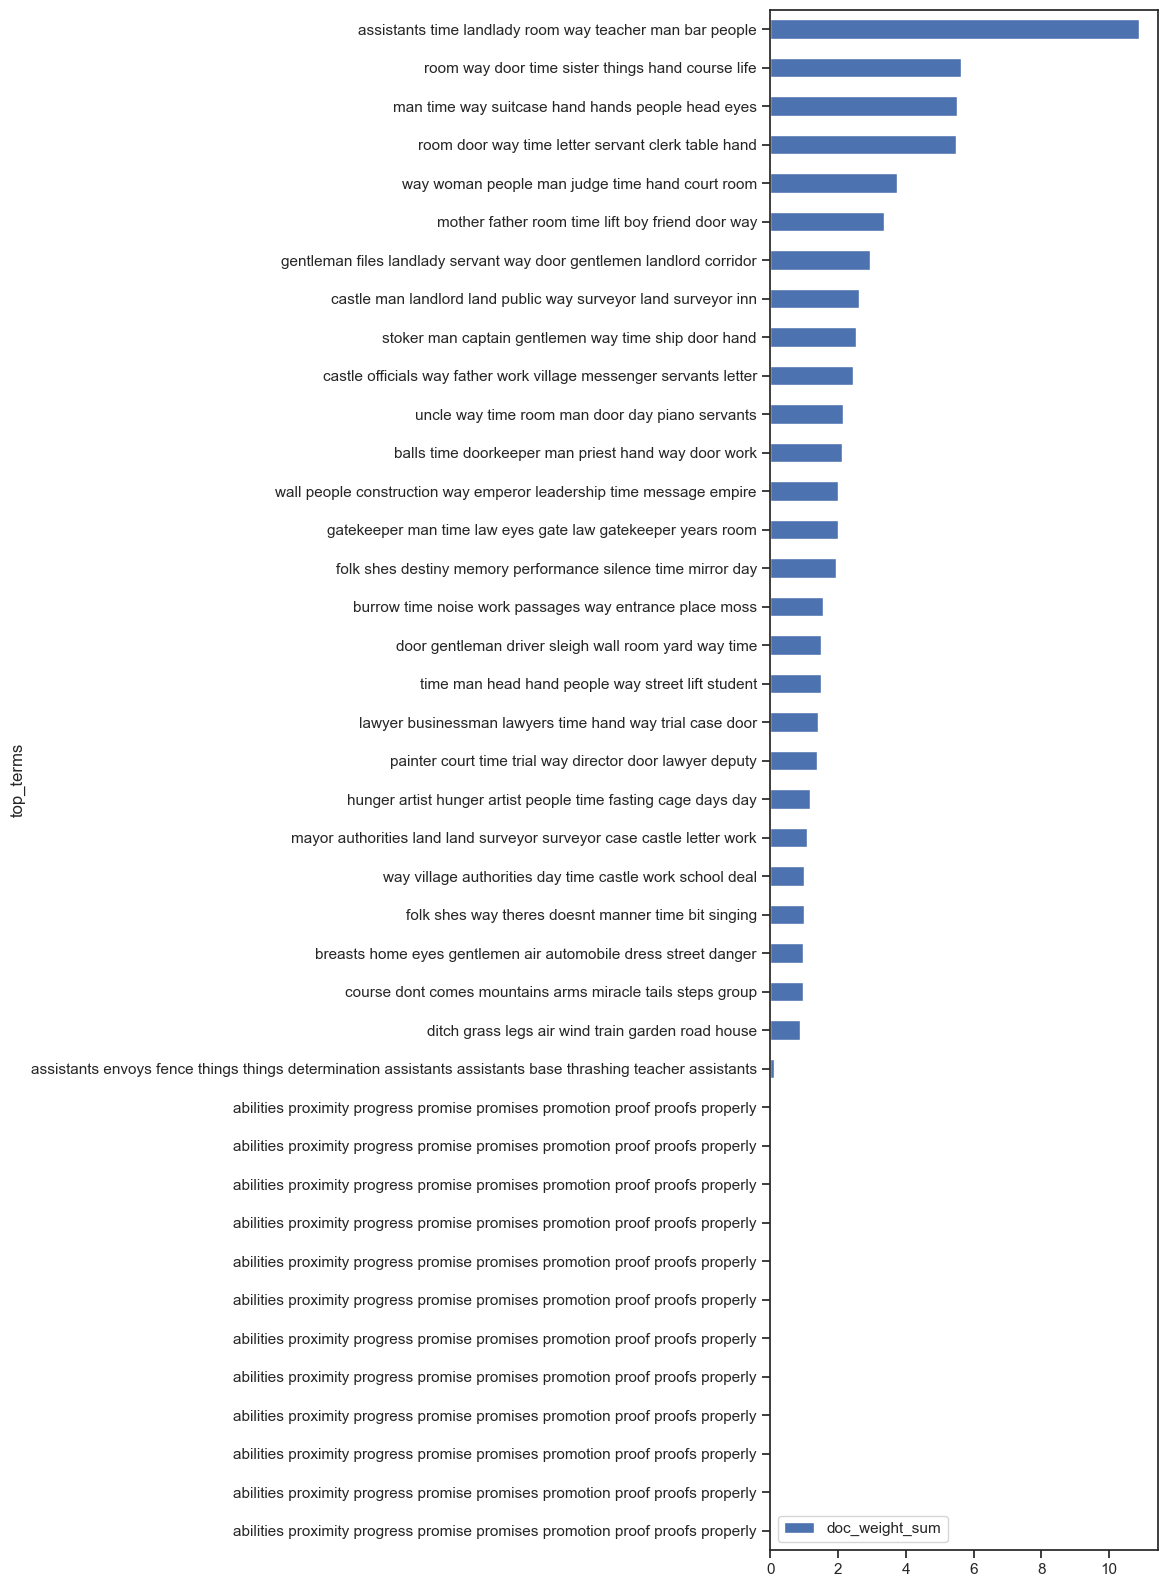

In [36]:
TOPICS.sort_values('doc_weight_sum', ascending=True).plot.barh(y='doc_weight_sum', x='top_terms', figsize=(5, n_topics/2));

<Axes: ylabel='top_terms'>

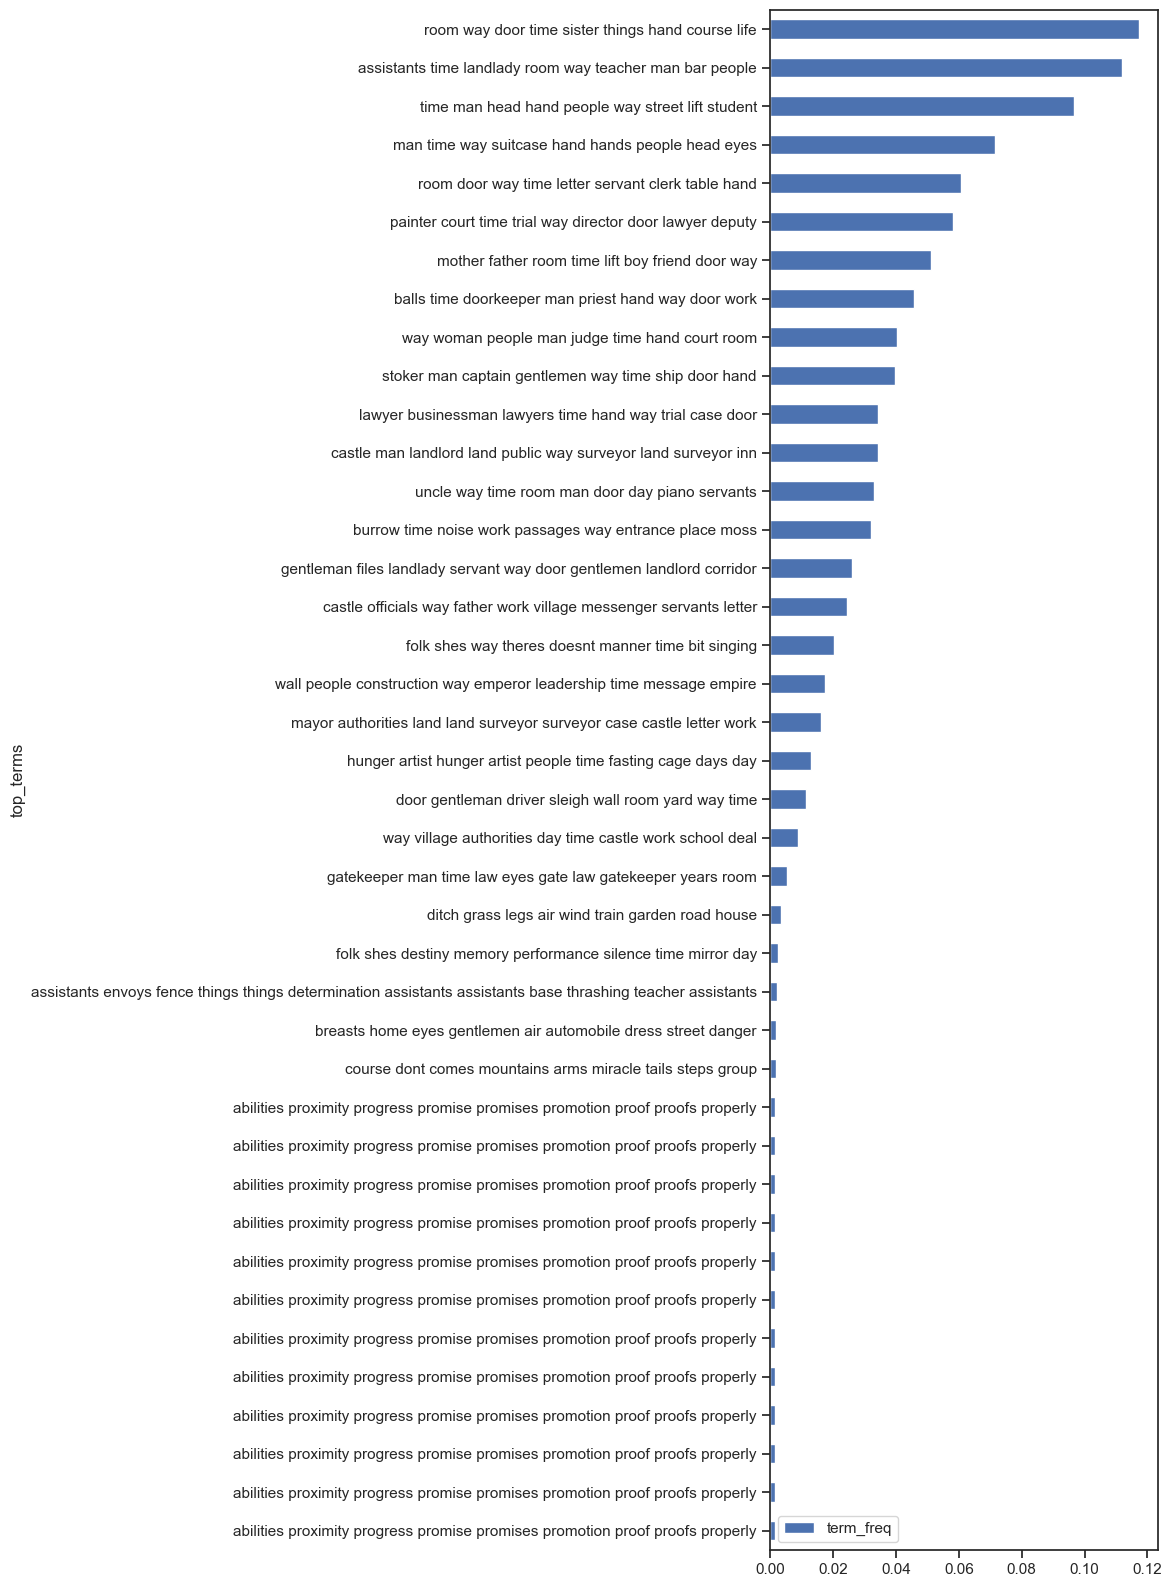

In [37]:
TOPICS.sort_values('term_freq', ascending=True).plot.barh(y='term_freq', x='top_terms', figsize=(5, n_topics/2))

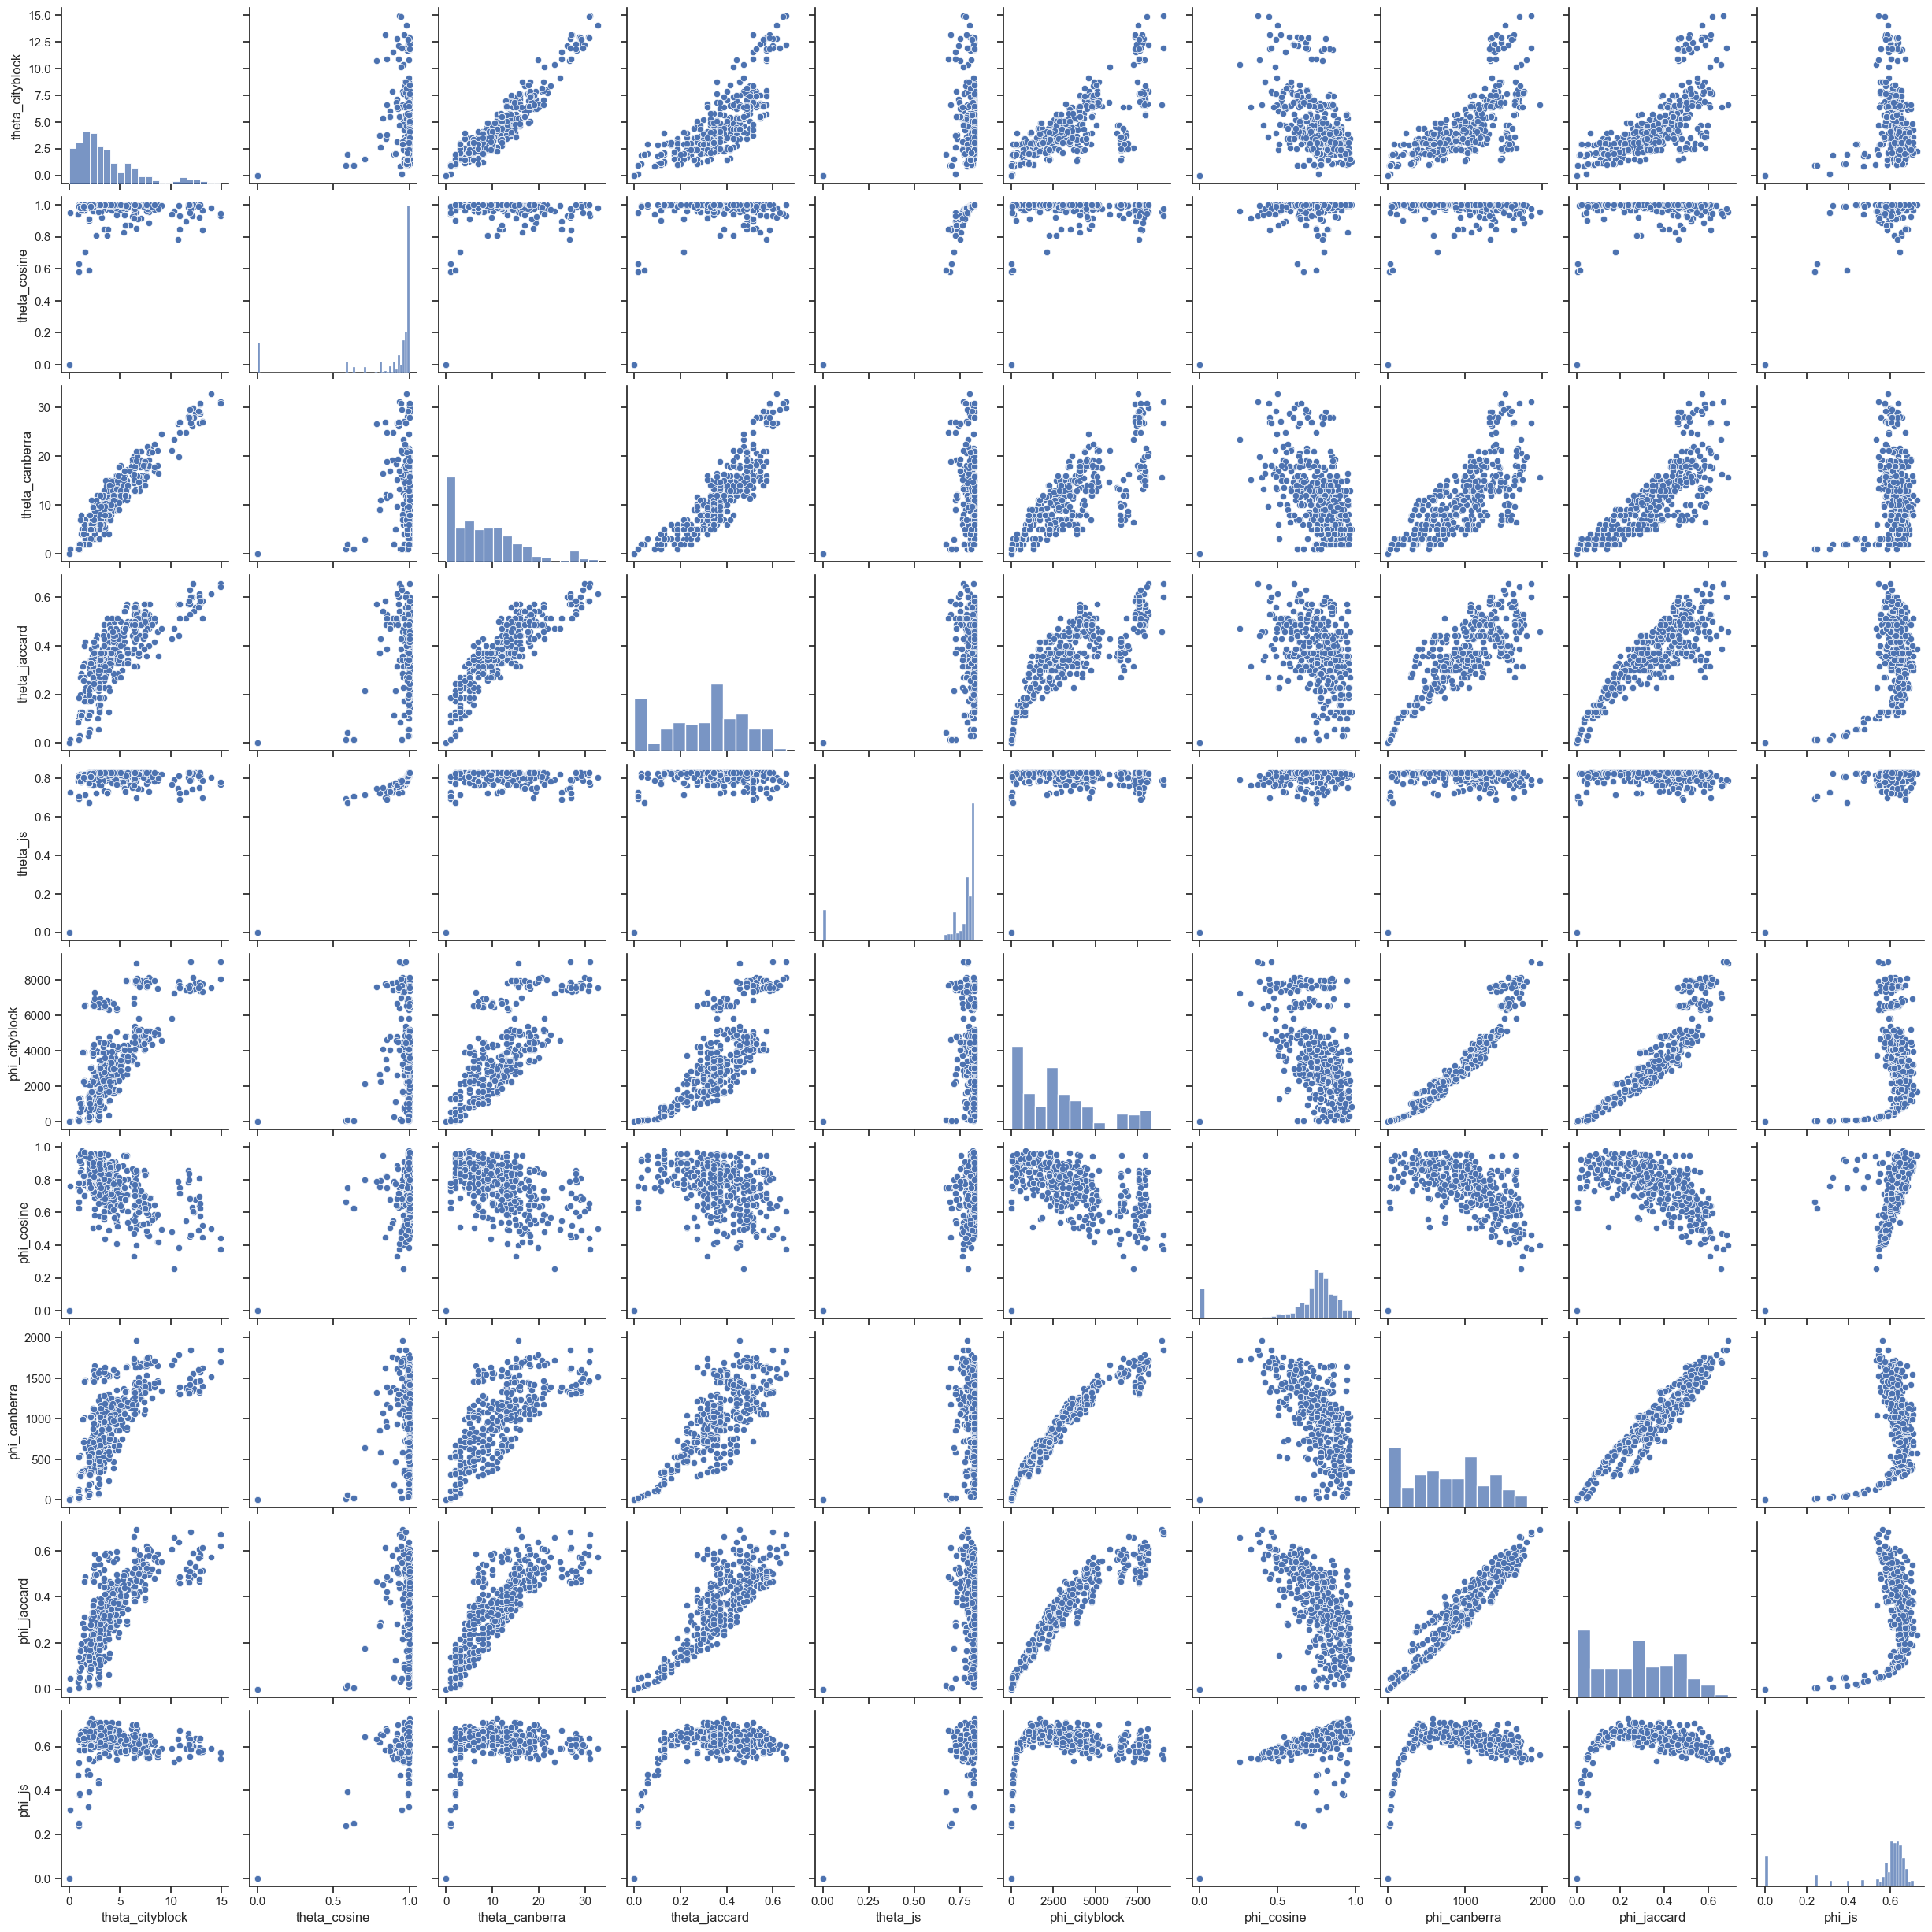

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from scipy.spatial.distance import pdist

tpairs_idx = [(a, b) for a, b in pd.MultiIndex.from_product([TOPICS.index, TOPICS.index]) if a < b]
TPAIRS = pd.DataFrame(tpairs_idx, columns=['topic_id_x', 'topic_id_y']).set_index(['topic_id_x', 'topic_id_y'])
TPAIRS['theta_cityblock'] = pdist(THETA.T, 'cityblock')
TPAIRS['theta_cosine'] = pdist(THETA.T, 'cosine')
TPAIRS['theta_canberra'] = pdist(THETA.T, 'canberra')
TPAIRS['theta_jaccard'] = pdist(THETA.T, 'jaccard')
TPAIRS['theta_js'] = pdist(THETA.T, 'jensenshannon')
 
TPAIRS['phi_cityblock'] = pdist(PHI, 'cityblock')
TPAIRS['phi_cosine'] = pdist(PHI, 'cosine')
TPAIRS['phi_canberra'] = pdist(PHI, 'canberra')
TPAIRS['phi_jaccard'] = pdist(PHI, 'jaccard')
TPAIRS['phi_js'] = pdist(PHI, 'jensenshannon')

sns.pairplot(TPAIRS)

In [49]:
TOPICS['doc_weight_mean'] = THETA.mean()
TOPICS.sort_values('doc_weight_mean', ascending = False)

,top_terms,doc_weight_sum,term_freq,doc_weight_mean
topic_id,,,,
T38,assistants time landlady room way teacher man ...,10.883749,0.112011,0.155482
T04,room way door time sister things hand course life,5.624936,0.117394,0.080356
T30,man time way suitcase hand hands people head eyes,5.518326,0.071388,0.078833
T22,room door way time letter servant clerk table ...,5.479734,0.060742,0.078282
T10,way woman people man judge time hand court room,3.738960,0.040320,0.053414
T08,mother father room time lift boy friend door way,3.358673,0.051268,0.047981
T21,gentleman ﬁles landlady servant way door gentl...,2.944634,0.026123,0.042066
T01,castle man landlord land public way surveyor l...,2.634840,0.034395,0.037641
T05,stoker man captain gentlemen way time ship doo...,2.524714,0.039747,0.036067


In [56]:
#TOPICS.to_csv('TOPICS.csv')

In [57]:
#THETA.to_csv('THETA.csv')

In [58]:
#PHI.to_csv('PHI.csv')

In [64]:
#DTM.to_csv('TOPICS_countmatrix.csv')